# __Elaborating susceptibility map with the trained neural network__
- Dataset: Guarujá Municipality - São Paulo - Brazil
- Part 3/3

## Authorship:
        Caio Azevedo
        São Paulo University, February, 2024

## Main goals:

- Tratamento dos dados para aplicação da rede neural: 
   - remoção de features irrelevantes;
   - normalização do dataset;
   - separação do dados de treino e teste da rede neural

- Treinamento e avaliação das redes neurais:
   - implementação keras
   - implementação customizada

- Automação do setup dos hiperparâmetros para melhor desempenho (critério inicial acurácia).
  - em __15-08-2021__ - Uso Keras Tuning para otimização dos hyperparameters Keras (vide arquivo .ipynb)
  - em __29-08-2021__ - Força Bruta para otimização dos hiperparametros na rede customizada

- Avaliar performance da rede com e sem 'features irrelevantes'.



## Coding

### Imported libraries

In [1]:
import Rede_Neural as rna
from Rede_Neural import NeuralNetwork
from Rede_Neural import Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from utils import plot

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

import statistics 

import os, sys

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow as tf

### Auxiliary functions

In [4]:
# split data into training, validation and testing sets
def dataPreparation(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training, validation and testing sets
    seed = 7
    test_size = 0.30
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)
    train_x, val_x, train_y, val_y   = train_test_split(train_x,train_y, test_size=test_size, shuffle=False)

    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(train_x)
    # scale the training dataset
    train_x = scaler.transform(train_x)
    # scale the test dataset
    test_x = scaler.transform(test_x)
    # scale the test dataset
    val_x = scaler.transform(val_x)
    return train_x, test_x, val_x, train_y, test_y, val_y

In [5]:
#divide o dataset em treino-teste-validação
def dataPreparation2(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training, validation and testing sets
    seed = 7
    test_size = 0.30
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)
    train_x, val_x, train_y, val_y   = train_test_split(train_x,train_y, test_size=test_size, shuffle=False)
    
    myTest = test_x

    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(train_x)
    # scale the training dataset
    train_x = scaler.transform(train_x)
    # scale the test dataset
    test_x = scaler.transform(test_x)
    # scale the test dataset
    val_x = scaler.transform(val_x)
    return train_x, test_x, val_x, train_y, test_y, val_y, myTest

In [6]:
#divide o dataset em treino-teste-validação
def dataPreparation3(dataSet):
    
    #dataSet.rename(columns={'TWI': 'twi','Curvatura': 'curv', 'Declividade': 'slope','Elevacao': 'elevation','Aspecto': 'aspect', 'Geologia': 'lito', 'Uso': 'uso_solo'}, inplace=True)
    #dataSet = dataSet[['FID','X','Y','slope','aspect','elevation','uso_solo','lito','twi','curv','class']]

    
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training, validation and testing sets
    seed = 7
    test_size = 0.30
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)
    train_x, val_x, train_y, val_y   = train_test_split(train_x,train_y, test_size=test_size, shuffle=False)
    
    myTest = test_x
    
    train_x = train_x[:,3:]
    test_x = test_x[:,3:]
    val_x = val_x[:,3:]
    #test_x = test_x[['slope','aspect','elevation','uso_solo','lito','twi','curv','class']]
    #val_x = val_x[['slope','aspect','elevation','uso_solo','lito','twi','curv','class']]
    

    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(train_x)
    # scale the training dataset
    train_x = scaler.transform(train_x)
    # scale the test dataset
    test_x = scaler.transform(test_x)
    # scale the test dataset
    val_x = scaler.transform(val_x)
    return train_x, test_x, val_x, train_y, test_y, val_y, myTest

In [7]:
# Plot a bubble chart with two features according to NN classification
def bubble_chart(data, col_2_buble_size, col_x, col_y):
    fig, ax = plt.subplots(figsize=(15,13))
    sizes = data[col_2_buble_size]*10
    scatter = ax.scatter(data[col_x], data[col_y], 
           c=(data['class']), cmap='rainbow', alpha=0.5,
           s=sizes, edgecolors='none')

    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    ax.title.set_text("{}{}".format(len(data.index), ' landslides samples')) 

    plt.show()

In [8]:
# Plot a bubble chart with two features according to NN classification and the actual values
def  bubble_double_chart(data, col_2_buble_size, col_x, col_y, accuracy):
    sizes = data[col_2_buble_size]*10

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

    scatter = axes[0].scatter(data[col_x], data[col_y],
            c=(data['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
    legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    scatter = axes[1].scatter(data[col_x], data[col_y],
            c=(data['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
    legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    fig.tight_layout()
    text = 'predicted landslides ' + 'accuracy : {:.2f}%'.format(accuracy)
    axes[0].title.set_text('actual landslides')
    axes[1].title.set_text(text)
    
    # common axis labels
    fig.supxlabel(col_x,fontsize=14)
    fig.supylabel(col_y,fontsize=14)

    plt.show()

In [9]:
#Chart that displays each features in regarding to predicted value
def plotSwarmChart(dataSet):
    dataSet['Constant'] = 0 #dummy feature used as reference

    f, axes = plt.subplots(1, 7, figsize=(35, 17), sharex=False)
    f.subplots_adjust(hspace=0.2, wspace=0.7)
    
    sns.catplot(x=dataSet.columns[6], y='score', kind="swarm", hue='score', data=dataSet,ax=axes[6])
    
    for i in range(7):
        col = dataSet.columns[i] 
        ax = sns.swarmplot(x=dataSet['Constant'],y=dataSet[col].values,hue=(dataSet['score']>0.5),ax=axes[i])
        ax.set_title(col)
        
    plt.close(2)
    plt.close(3)
    plt.show()

In [10]:
# Compute and print ROC curve
def printAUROC(y_real,y_predict):
    ns_auc = roc_auc_score(y_real, y_predict)
    # summarize scores
    print('AUC ROC=%.4f' % (ns_auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_real, y_predict)
    random_probs = [0 for i in range(len(y_real))]
    p_fpr, p_tpr, _ = roc_curve(y_real, random_probs, pos_label=1)
    # plot the roc curve for the model
    plt.plot(p_fpr, p_tpr, linestyle='--', label='random', color='orange')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ANN', color='blue')
    
    # axis labels
    pyplot.xlabel('false positive rate')
    pyplot.ylabel('true positive rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [11]:
# Compute and display performance metrics 
def NetworkPerformance(y_real, y_prob):
    y_predict = (y_prob > 0.5)
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_real, y_predict)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_real, y_predict)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_real, y_predict)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_real, y_predict)
    print('F1 score: %f' % f1)
    # kappa
    kappa = cohen_kappa_score(y_real, y_predict)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_real, y_prob)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_real, y_predict)
    print(matrix)

In [12]:
def out_file_name(input_file_name):
    folder_bestANN = 'bestANN\\'
    folder_bestMap = 'bestANN\maps\\'
    
    if not os.path.exists(folder_bestANN):
      os.mkdir(folder_bestANN)
    if not os.path.exists(folder_bestMap):
      os.mkdir(folder_bestMap)
    
    out_f = os.path.splitext(input_file_name)[0]
    
    out_NN_custom = folder_bestANN + 'customNN_' + out_f + '.pkl'
    out_NN_keras  = folder_bestANN + 'kerasNN_' + out_f

    out_file_map_custom = folder_bestMap + 'customMap_' + out_f + '.csv'
    out_file_map_keras = folder_bestMap + 'kerasMap_' + out_f + '.csv'
    
    
    return out_NN_custom, out_NN_keras, out_file_map_custom,out_file_map_keras

### Select the dataset

In [13]:
APP_PATH = os.getcwd()
#file = "guaruja_radius_50m_shuffled.csv"
#file = "guaruja_radius_100m_shuffled.csv"
#file = "guaruja_radius_150m_shuffled.csv"
file = "guaruja_radius_200m_shuffled.csv"

#file = "guaruja_buffer_1km_shuffled.csv"
#file = "guaruja_buffer_2km_shuffled.csv"
#file = "guaruja_buffer_3km_shuffled.csv"
#file = "guaruja_buffer_4km_shuffled.csv"

#file = "guaruja_random.csv"

dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", file))) 

# load the dataset
dataset_original = dataset.copy()
dataset.head(5)

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class
0,174,380188.0000,7355077.000,4.319798,-0.015372,33.860043,25.912239,277.485138,65,90,1
1,1,369756.0000,7344220.000,16.590740,-0.043386,0.727488,0.418544,159.017288,2,90,0
2,62,376611.0000,7353497.000,16.493561,-0.011949,1.114157,1.117189,142.506317,2,90,0
3,110,372569.0000,7346250.000,5.782696,-0.010980,20.309313,9.144706,306.605927,2,30,1
4,109,370946.0334,7346022.025,4.132583,-0.000184,43.904831,46.628563,316.640686,2,30,1


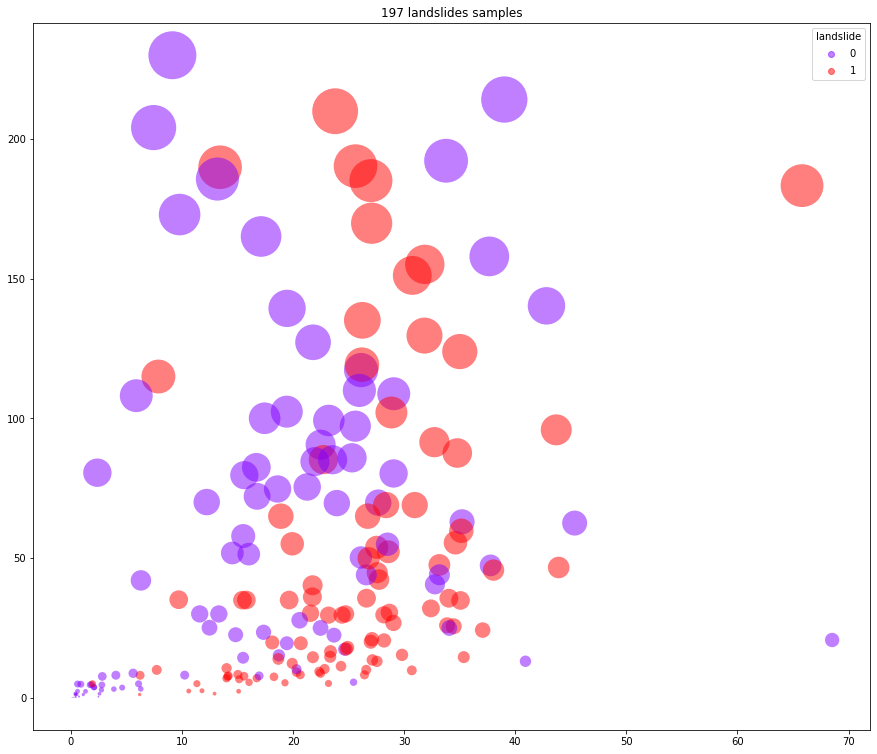

In [14]:
bubble_chart(dataset,"elevation","slope","elevation")

### Data Preparation
 - Based on the results of the feature importance analysis, all features were retained for training the ANN.
 - We addressed concerns about data leakage.
 - Train-Test Evaluation With Correct Data Preparation
 - Data Preparation With k-fold Cross-Validation

In [15]:
dataset = dataset[['slope','aspect','elevation','land_use','lithology','twi','curvature','class']]

#dataset = dataset.drop('slope',axis=1)
#dataset = dataset.drop('aspect',axis=1)

#dataset = dataset.drop('lithology',axis=1)
#dataset = dataset.drop('curvature',axis=1)

#dataset = dataset.drop('elevation',axis=1)
#dataset = dataset.drop('land_use',axis=1)

#dataset.head(5)

In [16]:
dataset.shape

(197, 8)

In [17]:
#describing the dataframe to seek for distribution information
dataset.describe().round(2)

,slope,aspect,elevation,land_use,lithology,twi,curvature,class
count,197.00,197.00,197.00,197.00,197.00,197.00,197.00,197.0
mean,19.82,200.24,47.63,69.64,33.34,5.82,0.12,0.5
std,12.34,105.75,54.07,29.94,31.58,3.01,2.04,0.5
min,0.03,0.30,0.00,20.00,2.00,1.37,-18.47,0.0
25%,11.59,108.77,7.82,30.00,2.00,4.03,-0.02,0.0
50%,20.69,202.57,25.91,90.00,2.00,4.96,-0.00,1.0
75%,27.52,302.54,69.85,90.00,65.00,6.41,0.02,1.0
max,68.52,359.51,230.08,120.00,65.00,16.59,11.10,1.0


In [18]:
#X_train, X_test, X_val, y_train, y_test, y_val, unSeenDS = dataPreparation2(dataset)
X_train, X_test, X_val, y_train, y_test, y_val = dataPreparation(dataset)
#X_train, X_test, X_val, y_train, y_test, y_val, unSeenDS = dataPreparation3(dataset_original)

In [19]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')
#print(len(unSeenDS), 'test (not scaled) examples')

95 train examples
42 validation examples
60 test examples


In [20]:
print(X_test.min(axis=0), X_test.max(axis=0))

[-0.99866932 -0.96642169 -1.00009425 -1.         -1.         -1.16903795
 -6.80518688] [1.08254853 1.03161732 1.1480696  1.85714286 1.         0.81881985
 2.3282485 ]


In [21]:
X = np.concatenate((X_train, X_val))
X = np.concatenate((X, X_test))
X.shape

(197, 7)

In [22]:
y = np.concatenate((y_train, y_val))
y = np.concatenate((y, y_test))
y.shape

(197, 1)

In [23]:
NN_custom, NN_keras, out_file_map_custom, out_file_map_keras  = out_file_name(file)

### Custom neural network

#### Assessment

In [24]:
#unSeenDS= np.c_[ unSeenDS, y_test ]
#unSeenDS.shape

In [25]:
#unSeenDS = pd.DataFrame(unSeenDS,columns=['FID','X','Y','slope','aspect','elevation','uso_solo','lito','twi','curv','class'])

In [26]:
#unSeenDS.head()

In [27]:
bestNN = None 
bestNN = NeuralNetwork.load(NN_custom)

#bestNN = NeuralNetwork.load('bestANN\susceptibilityNN-Input_Guaruja_aleatorio_shuffled_98.50.pkl')
#bestNN = NeuralNetwork.load('bestANN\susceptibilityNN-Input_Guaruja_200m_shuffled_93.91.pkl')
#bestNN = NeuralNetwork.load('bestANN\susceptibilityNN-Input_Guaruja_200m_shuffled_95.43.pkl')
print('Custom ANN loaded from \033[1m{}\033[0m!'.format(NN_custom))

Custom ANN loaded from bestANN\customNN_guaruja_radius_200m_shuffled.pkl!


In [28]:
y_pred = bestNN.predict(X_train)
print('\033[1mTraining sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y_train, y_pred > 0.5)))
NetworkPerformance(y_train, y_pred)

Training sample accuracy: 100.00%
Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[38  0]
 [ 0 57]]


AUC ROC=1.0000


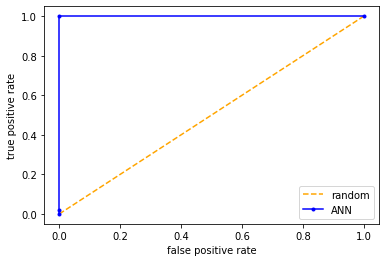

In [29]:
printAUROC(y_train,y_pred)

In [30]:
y_pred = bestNN.predict(X_val)
print('\033[1mValidation sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y_val, y_pred > 0.5)))
NetworkPerformance(y_val, y_pred)

Validation sample accuracy: 92.86%
Accuracy: 0.928571
Precision: 0.913043
Recall: 0.954545
F1 score: 0.933333
Cohens kappa: 0.856492
ROC AUC: 0.938636
[[18  2]
 [ 1 21]]


AUC ROC=0.9386


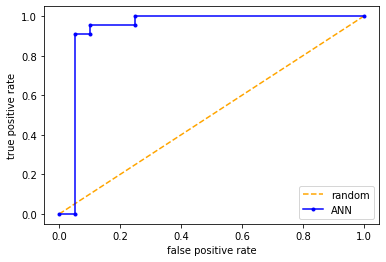

In [31]:
printAUROC(y_val,y_pred)

In [32]:
y_pred = bestNN.predict(X_test)
print('\033[1mTest sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y_test, y_pred > 0.5)))
NetworkPerformance(y_test, y_pred)

Test sample accuracy: 86.67%
Accuracy: 0.866667
Precision: 0.750000
Recall: 0.900000
F1 score: 0.818182
Cohens kappa: 0.714286
ROC AUC: 0.896250
[[34  6]
 [ 2 18]]


AUC ROC=0.8962


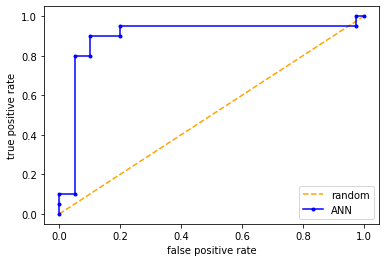

In [33]:
printAUROC(y_test,y_pred)

In [34]:
NetworkPerformance(y_test, (y_pred > 0.5))

Accuracy: 0.866667
Precision: 0.750000
Recall: 0.900000
F1 score: 0.818182
Cohens kappa: 0.714286
ROC AUC: 0.875000
[[34  6]
 [ 2 18]]


AUC ROC=0.8962


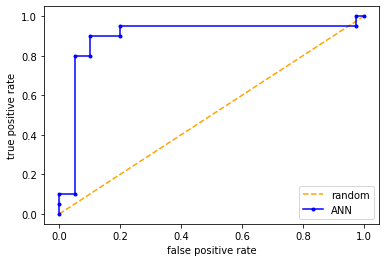

In [35]:
printAUROC(y_test,y_pred)

In [36]:
y_pred = bestNN.predict(X)
print('\033[1mOverall sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y, y_pred > 0.5)))
NetworkPerformance(y, y_pred)

Overall sample accuracy: 94.42%
Accuracy: 0.944162
Precision: 0.923077
Recall: 0.969697
F1 score: 0.945813
Cohens kappa: 0.888293
ROC AUC: 0.955885
[[90  8]
 [ 3 96]]


AUC ROC=0.9559


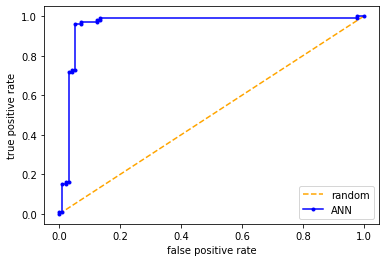

In [37]:
printAUROC(y,y_pred)

In [38]:
y_pred = bestNN.predict(X)
yhat_classes = (y_pred > 0.5)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
output_dataset = None
output_dataset = dataset_original
output_dataset['score'] = y_pred
output_dataset.to_csv(out_file_map_custom, encoding="utf-8")

Accuracy: 94.42%


In [39]:
cf_matrix = confusion_matrix(y,(y_pred > 0.5))

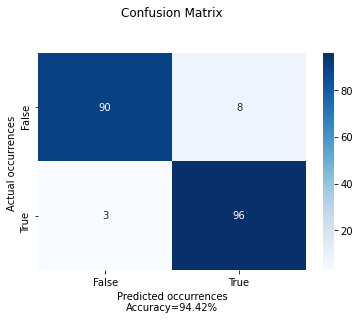

In [40]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('Predicted occurrences\nAccuracy={:0.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
ax.set_ylabel('Actual occurrences ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

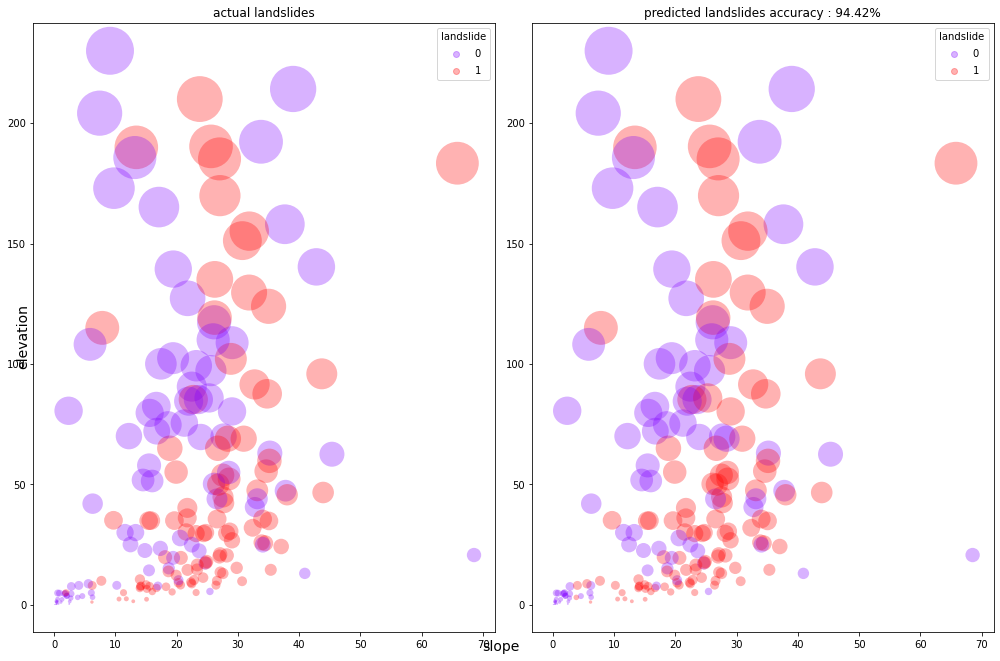

In [41]:
bubble_double_chart(output_dataset,"elevation","slope","elevation",100*accuracy_score(y, y_pred > 0.5))

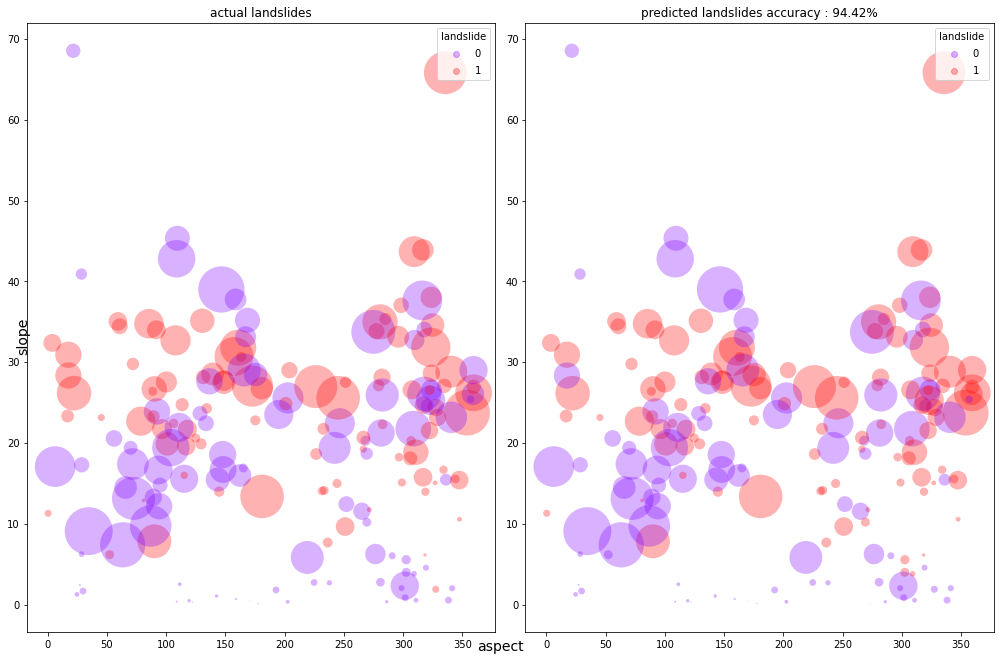

In [42]:
bubble_double_chart(output_dataset,"elevation","aspect","slope",100*accuracy_score(y, y_pred > 0.5))

#### RepeatedStratifiedKFold Assessment

In [43]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Numero de Splits_stratified de X: ',rskf.get_n_splits(X, y),'\n')

# Prin_stratifiedting the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified, X_test_stratified = X[train_index], X[test_index]
    y_train_stratified, y_test_stratified = y[train_index], y[test_index]
    print(X_train_stratified.shape, y_train_stratified.shape)
    
    yhat_probs = bestNN.predict(X_test_stratified)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified, yhat_probs > 0.5))

Numero de Splits_stratified de X:  10 

(157, 7) (157, 1)
(157, 7) (157, 1)
(158, 7) (158, 1)
(158, 7) (158, 1)
(158, 7) (158, 1)
(157, 7) (157, 1)
(157, 7) (157, 1)
(158, 7) (158, 1)
(158, 7) (158, 1)
(158, 7) (158, 1)


In [44]:
print('Lista de acurácias obtidas:', lst_accu_stratified)
print('\nAcurácia máxima obtida:',
      max(lst_accu_stratified), '%')
print('\nAcurácia mínima:',
      min(lst_accu_stratified), '%')
print('\nAcurácia média:',
      statistics.mean(lst_accu_stratified), '%')
print('\nDesvio Padrão:', statistics.stdev(lst_accu_stratified))

Lista de acurácias obtidas: [92.5, 95.0, 92.3076923076923, 100.0, 92.3076923076923, 95.0, 95.0, 92.3076923076923, 94.87179487179486, 94.87179487179486]

Acurácia máxima obtida: 100.0 %

Acurácia mínima: 92.3076923076923 %

Acurácia média: 94.41666666666666 %

Desvio Padrão: 2.3481826888562125


In [45]:
dataset

,slope,aspect,elevation,land_use,lithology,twi,curvature,class
0,33.860043,277.485138,25.912239,90,65,4.319798,-0.015372,1
1,0.727488,159.017288,0.418544,90,2,16.590740,-0.043386,0
2,1.114157,142.506317,1.117189,90,2,16.493561,-0.011949,0
3,20.309313,306.605927,9.144706,30,2,5.782696,-0.010980,1
4,43.904831,316.640686,46.628563,30,2,4.132583,-0.000184,1
...,...,...,...,...,...,...,...,...
192,28.372442,17.409184,68.982224,90,2,4.304924,4.304924,1
193,16.010031,162.229965,51.405090,90,65,5.160524,-2.031868,0
194,23.677940,128.533310,22.392719,90,65,4.225570,-0.711420,0
195,40.913528,28.399397,13.043623,90,2,2.448155,2.316771,0


#### Output map file

In [46]:
y_pred = bestNN.predict(X)
yhat_classes = (y_pred > 0.5)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
output_dataset = None
output_dataset = dataset_original
output_dataset['score'] = y_pred
output_dataset.to_csv(out_file_map_keras, encoding="utf-8")
print('Output file saved in \033[1m{}\033[0m!'.format(out_file_map_custom))

Accuracy: 94.42%
Output file saved in bestANN\maps\customMap_guaruja_radius_200m_shuffled.csv!


In [47]:
NetworkPerformance(y, (y_pred))

Accuracy: 0.944162
Precision: 0.923077
Recall: 0.969697
F1 score: 0.945813
Cohens kappa: 0.888293
ROC AUC: 0.955885
[[90  8]
 [ 3 96]]


AUC ROC=0.9559


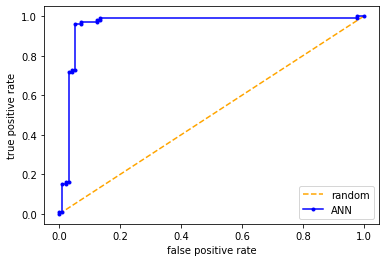

In [48]:
printAUROC(y,y_pred)

In [49]:
output_dataset

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class,score
0,174,380188.0000,7355077.000,4.319798,-0.015372,33.860043,25.912239,277.485138,65,90,1,9.996260e-01
1,1,369756.0000,7344220.000,16.590740,-0.043386,0.727488,0.418544,159.017288,2,90,0,1.327483e-06
2,62,376611.0000,7353497.000,16.493561,-0.011949,1.114157,1.117189,142.506317,2,90,0,2.172873e-07
3,110,372569.0000,7346250.000,5.782696,-0.010980,20.309313,9.144706,306.605927,2,30,1,9.999988e-01
4,109,370946.0334,7346022.025,4.132583,-0.000184,43.904831,46.628563,316.640686,2,30,1,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
192,169,377535.0937,7354527.194,4.304924,4.304924,28.372442,68.982224,17.409184,2,90,1,1.309919e-18
193,87,381307.0000,7356024.000,5.160524,-2.031868,16.010031,51.405090,162.229965,65,90,0,1.151543e-05
194,59,379144.0000,7353357.000,4.225570,-0.711420,23.677940,22.392719,128.533310,65,90,0,1.641044e-04
195,78,380890.0000,7355373.000,2.448155,2.316771,40.913528,13.043623,28.399397,2,90,0,2.067532e-11


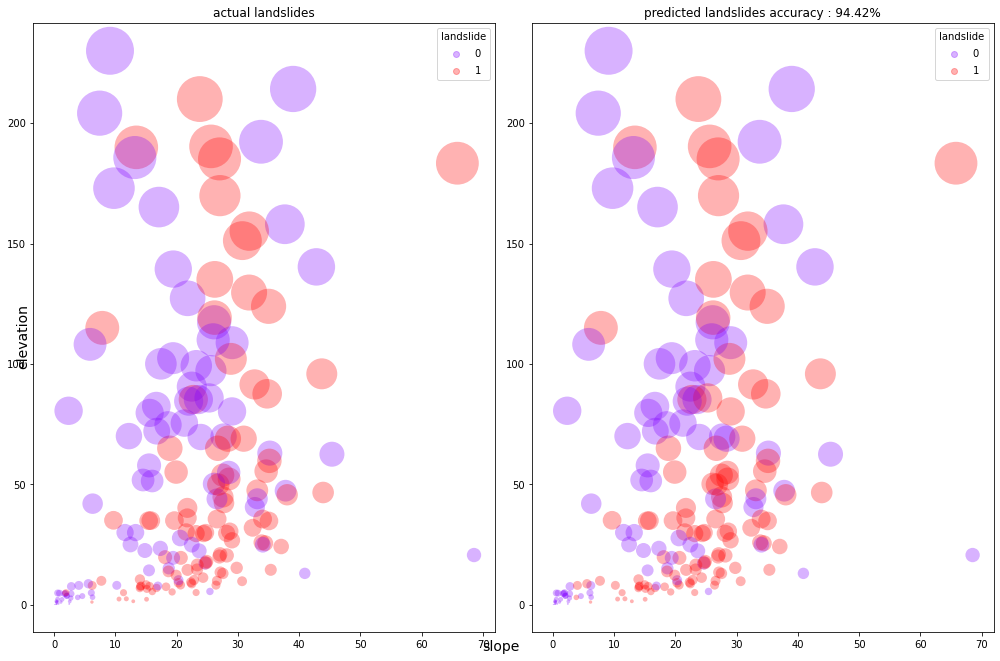

In [50]:
bubble_double_chart(output_dataset,"elevation","slope","elevation",100*accuracy_score(y, y_pred > 0.5))

C:\Users\cazev\miniconda3\envs\caio\lib\site-packages\seaborn\categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try swarmplot
  warnings.warn(msg, UserWarning)
C:\Users\cazev\miniconda3\envs\caio\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 39.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\cazev\miniconda3\envs\caio\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\cazev\miniconda3\envs\caio\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


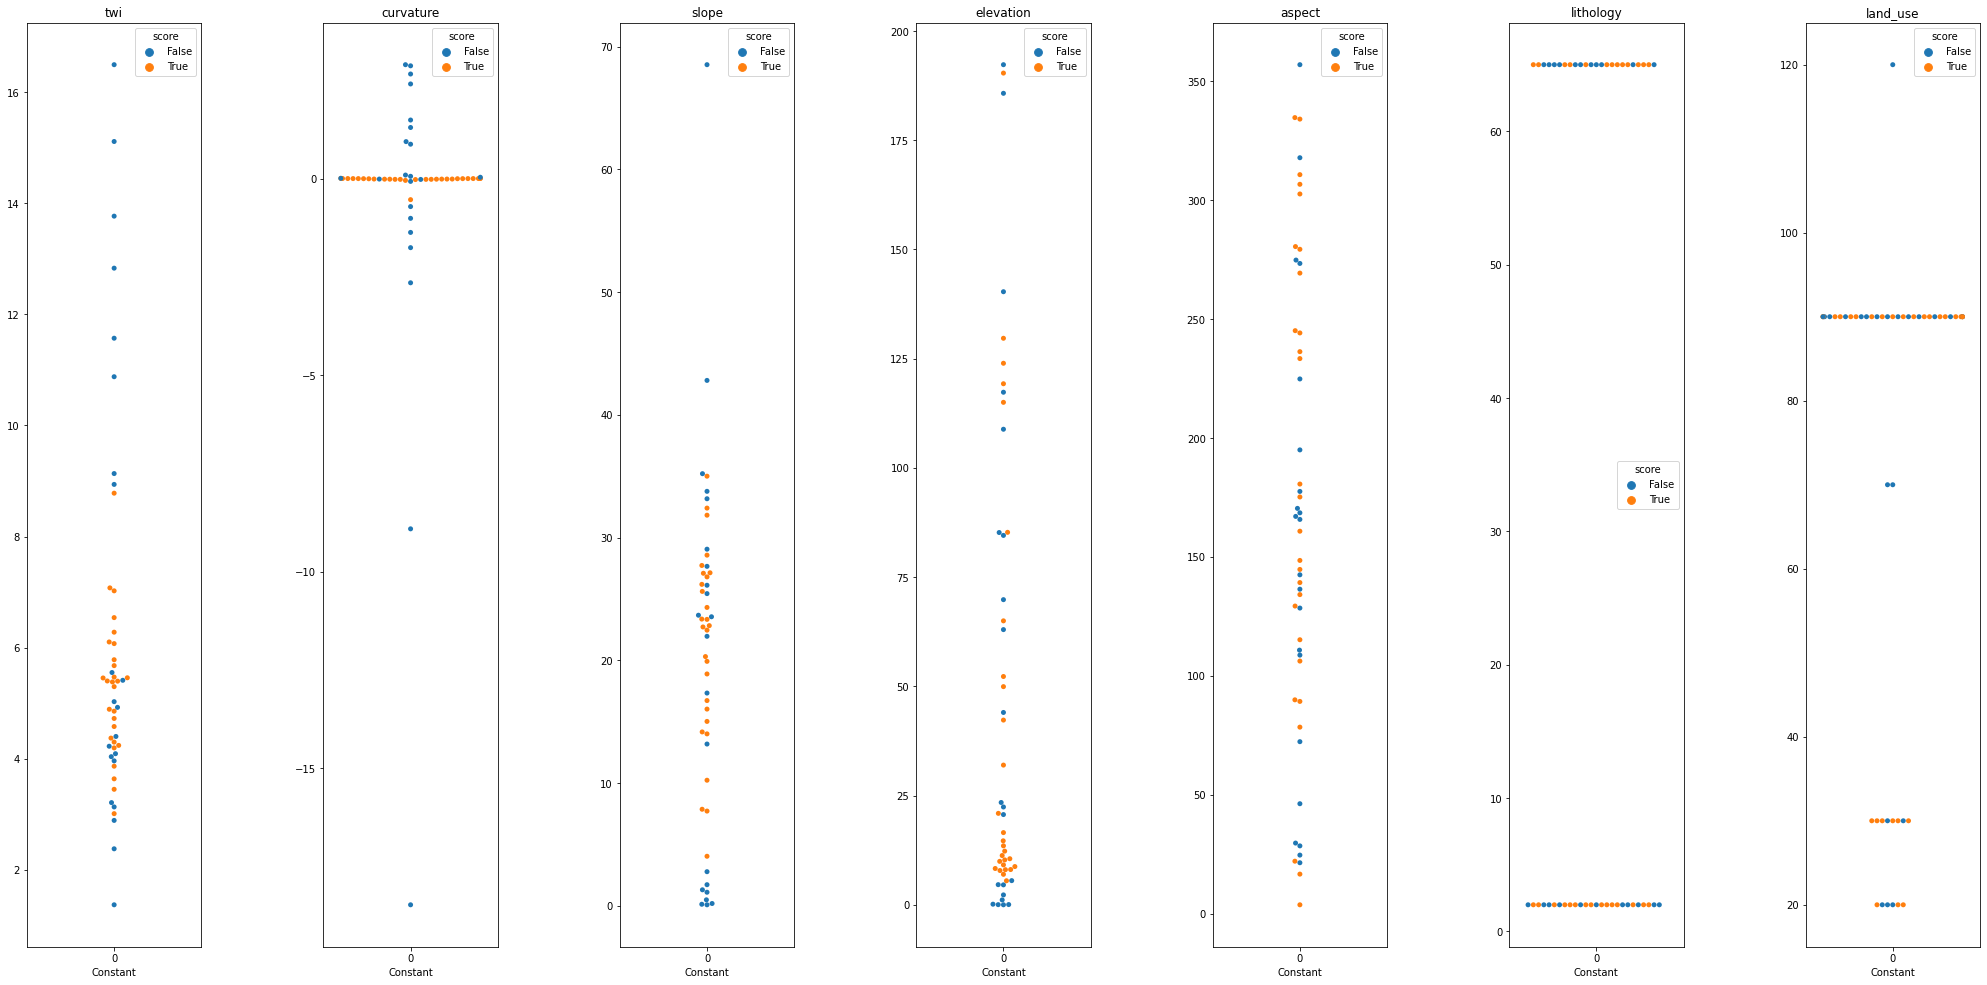

In [51]:
dataSet = output_dataset.sample(n = 50)
dataSet = dataSet.drop('FID',axis=1)
dataSet = dataSet.drop('X',axis=1)
dataSet = dataSet.drop('Y',axis=1)
plotSwarmChart(dataSet)

### Keras Framework

In [52]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

95 train examples
42 validation examples
60 test examples


__Recupera a melhor configuração de rede keras da otimização por força bruta (Keras tuner)__

In [53]:
hypermodel = keras.models.load_model(NN_keras)
print('Keras ANN loaded from \033[1m{}\033[0m!'.format(NN_keras))

Keras ANN loaded from bestANN\kerasNN_guaruja_radius_200m_shuffled!


#### Assessment

In [54]:
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

2/2 [==============================] - 0s 7ms/step - loss: 0.7512 - accuracy: 0.7667
Accuracy: 76.67


In [55]:
#HyperParameters: {'num_hidden_layers': 2, 'num_units': 12, 'dropout_rate': 0.2821478566400208, 'learning_rate': 0.006549533067877217}
#conjunto de hyperparametros para o Guaruja 87% acuracia dados de teste.

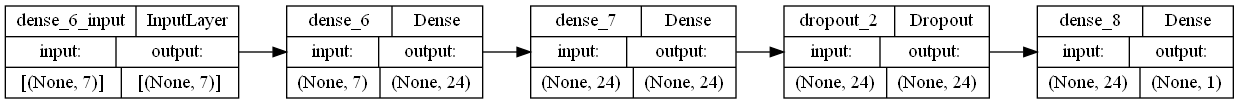

In [56]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(hypermodel, show_shapes=True, rankdir="LR")  

In [57]:
y_pred = hypermodel.predict(X_train)
print('Acurácia Treino: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

3/3 [==============================] - 0s 3ms/step
Acurácia Treino: 98.95%


In [58]:
NetworkPerformance(y_train, (y_pred > 0.5))

Accuracy: 0.989474
Precision: 0.982759
Recall: 1.000000
F1 score: 0.991304
Cohens kappa: 0.977974
ROC AUC: 0.986842
[[37  1]
 [ 0 57]]


AUC ROC=0.9995


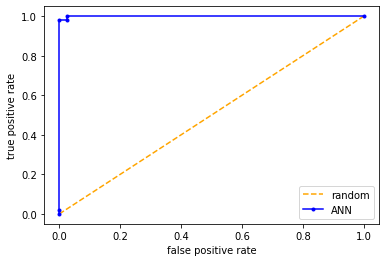

In [59]:
printAUROC(y_train,y_pred)

In [60]:
y_pred = hypermodel.predict(X_test)
print('Acurácia Treino: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

2/2 [==============================] - 0s 5ms/step
Acurácia Treino: 76.67%


In [61]:
NetworkPerformance(y_test, (y_pred > 0.5))

Accuracy: 0.766667
Precision: 0.615385
Recall: 0.800000
F1 score: 0.695652
Cohens kappa: 0.511628
ROC AUC: 0.775000
[[30 10]
 [ 4 16]]


AUC ROC=0.8475


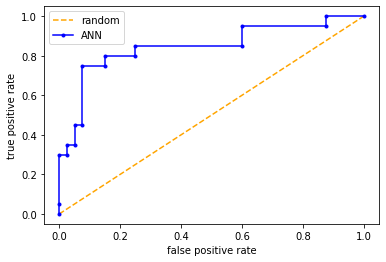

In [62]:
printAUROC(y_test,y_pred)

In [63]:
y_pred = hypermodel.predict(X_val)
print('Acurácia Treino: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

2/2 [==============================] - 0s 2ms/step
Acurácia Treino: 88.10%


In [64]:
NetworkPerformance(y_val, (y_pred > 0.5))

Accuracy: 0.880952
Precision: 0.814815
Recall: 1.000000
F1 score: 0.897959
Cohens kappa: 0.758621
ROC AUC: 0.875000
[[15  5]
 [ 0 22]]


AUC ROC=0.8886


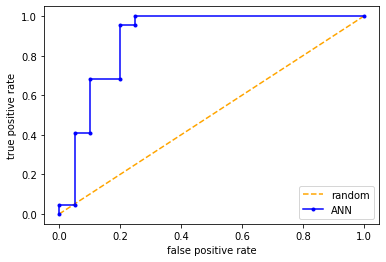

In [65]:
printAUROC(y_val,y_pred)

In [66]:
y_pred = hypermodel.predict(X)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

7/7 [==============================] - 0s 1ms/step
Acurácia: 89.85%


In [67]:
NetworkPerformance(y, (y_pred > 0.5))

Accuracy: 0.898477
Precision: 0.855856
Recall: 0.959596
F1 score: 0.904762
Cohens kappa: 0.796823
ROC AUC: 0.898165
[[82 16]
 [ 4 95]]


AUC ROC=0.9365


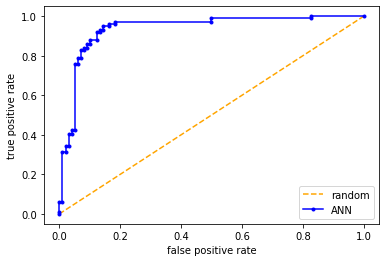

In [68]:
printAUROC(y,y_pred)

#### RepeatedStratifiedKFold Assessment

In [69]:
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=2,random_state=36851234)

print ('Splits numbers of X: ',rskf.get_n_splits(X, y),'\n')

# Printing the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified_keras, X_test_stratified_keras = X[train_index], X[test_index]
    y_train_stratified_keras, y_test_stratified_keras = y[train_index], y[test_index]
    #print(X_train_stratified_keras.shape, y_train_stratified_keras.shape)
    
    yhat_probs = hypermodel.predict(X_test_stratified_keras)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified_keras, yhat_probs > 0.5))

Splits numbers of X:  20 

1/1 [==============================] - 0s 18ms/step


In [70]:
print('List of obtained accuracies:', lst_accu_stratified)
print('\nMaximum accuracy:',
      max(lst_accu_stratified), '%')
print('\nMinimum accuracy:',
      min(lst_accu_stratified), '%')
print('\nAvarage accuracy:',
      statistics.mean(lst_accu_stratified), '%')
print('\nStandard deviation:', statistics.stdev(lst_accu_stratified))

List of obtained accuracies: [95.0, 80.0, 90.0, 95.0, 85.0, 90.0, 85.0, 100.0, 89.47368421052632, 89.47368421052632, 100.0, 100.0, 90.0, 80.0, 80.0, 90.0, 85.0, 94.73684210526315, 94.73684210526315, 84.21052631578947]

Maximum accuracy: 100.0 %

Minimum accuracy: 80.0 %

Avarage accuracy: 89.88157894736842 %

Standard deviation: 6.503711076264256


#### Output map file

In [71]:
output_keras = None
output_keras = dataset_original
output_keras['score'] = y_pred
output_keras.to_csv(out_file_map_keras, encoding="utf-8")
output_keras

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class,score
0,174,380188.0000,7355077.000,4.319798,-0.015372,33.860043,25.912239,277.485138,65,90,1,9.467611e-01
1,1,369756.0000,7344220.000,16.590740,-0.043386,0.727488,0.418544,159.017288,2,90,0,1.086364e-07
2,62,376611.0000,7353497.000,16.493561,-0.011949,1.114157,1.117189,142.506317,2,90,0,7.160678e-08
3,110,372569.0000,7346250.000,5.782696,-0.010980,20.309313,9.144706,306.605927,2,30,1,9.929277e-01
4,109,370946.0334,7346022.025,4.132583,-0.000184,43.904831,46.628563,316.640686,2,30,1,9.963724e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
192,169,377535.0937,7354527.194,4.304924,4.304924,28.372442,68.982224,17.409184,2,90,1,1.996073e-04
193,87,381307.0000,7356024.000,5.160524,-2.031868,16.010031,51.405090,162.229965,65,90,0,1.920078e-02
194,59,379144.0000,7353357.000,4.225570,-0.711420,23.677940,22.392719,128.533310,65,90,0,3.544877e-01
195,78,380890.0000,7355373.000,2.448155,2.316771,40.913528,13.043623,28.399397,2,90,0,4.165857e-01


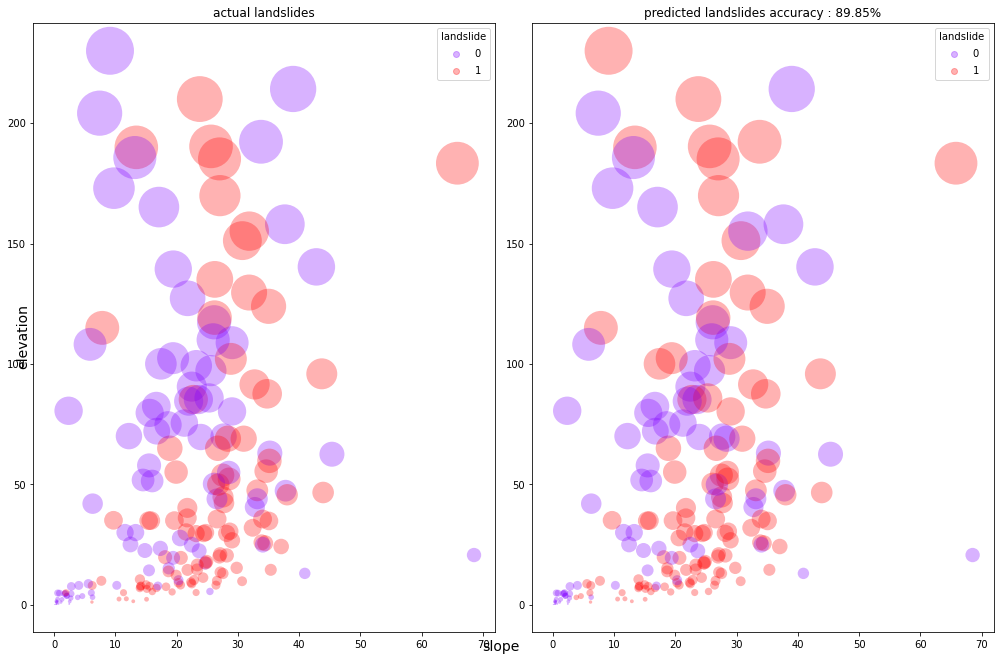

In [72]:
bubble_double_chart(output_dataset,"elevation","slope","elevation",100*accuracy_score(y, y_pred > 0.5))

C:\Users\cazev\miniconda3\envs\caio\lib\site-packages\seaborn\categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try swarmplot
  warnings.warn(msg, UserWarning)
C:\Users\cazev\miniconda3\envs\caio\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


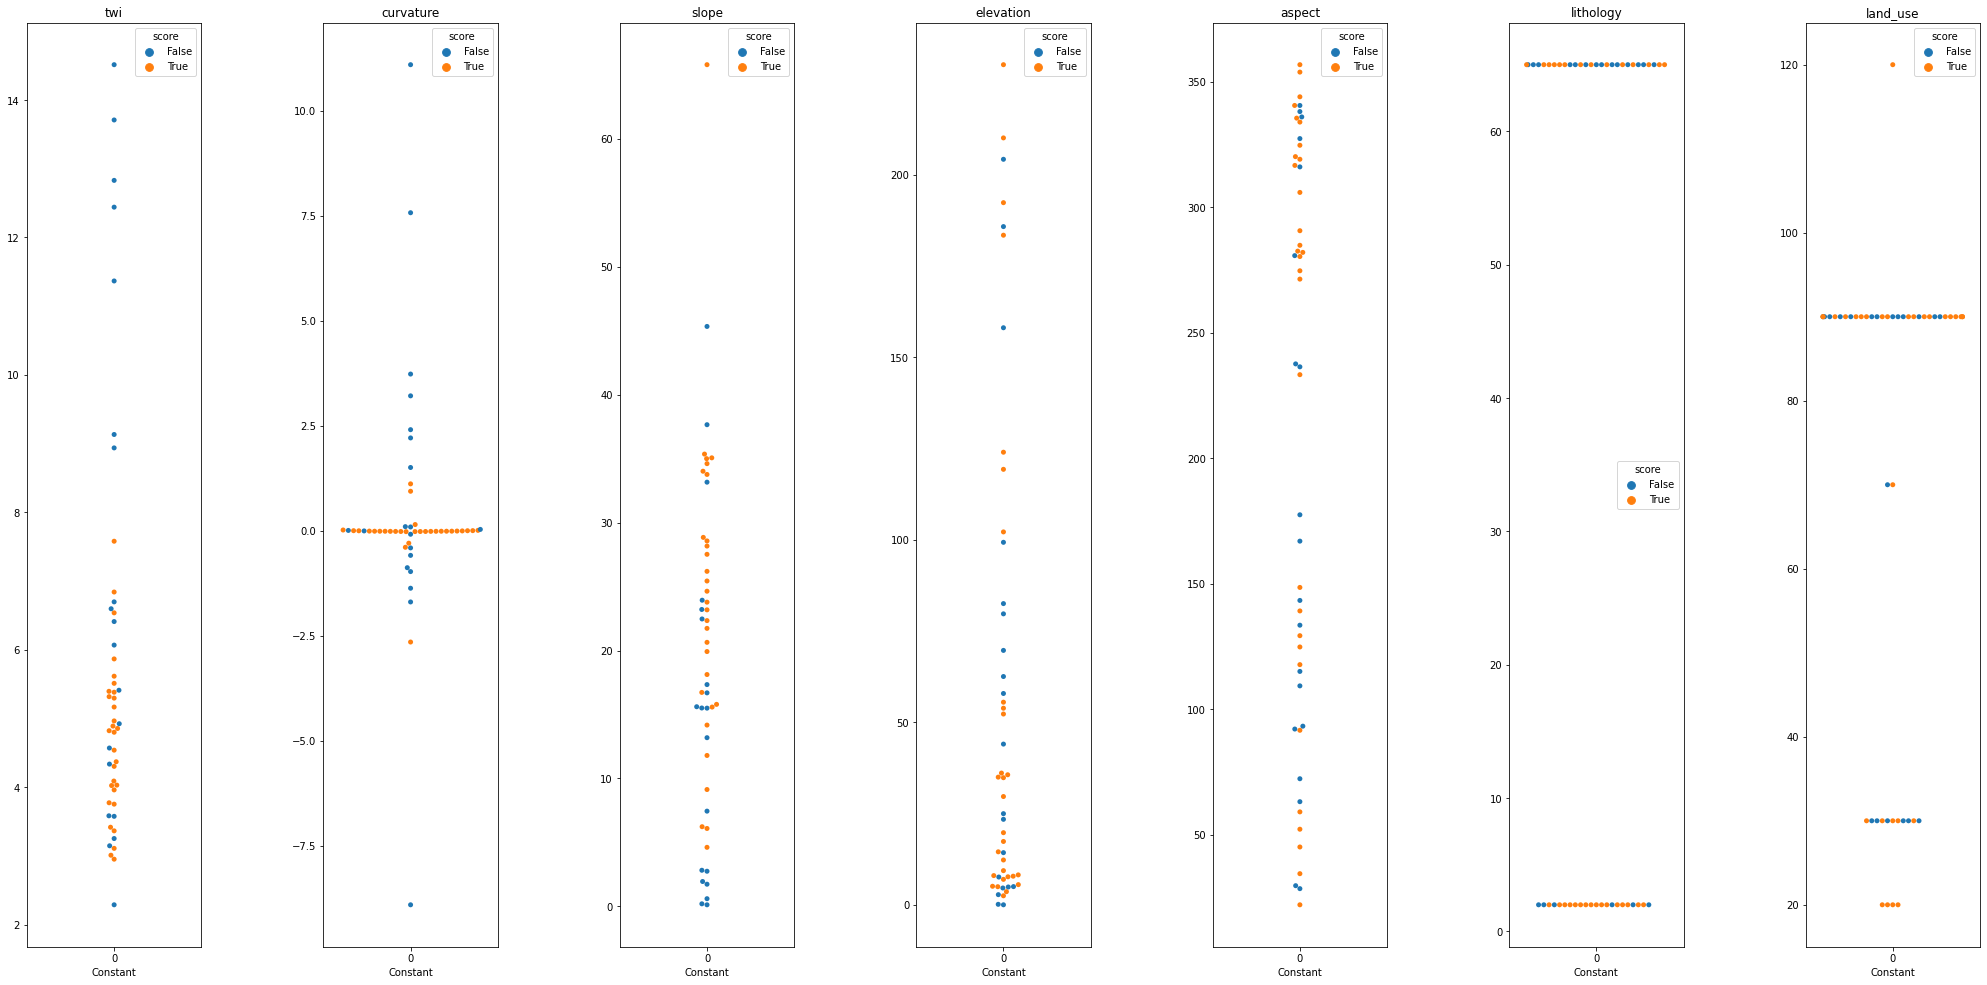

In [73]:
dataSet = output_keras.sample(n = 50)
dataSet = dataSet.drop('FID',axis=1)
dataSet = dataSet.drop('X',axis=1)
dataSet = dataSet.drop('Y',axis=1)
plotSwarmChart(dataSet)

## References

- ref. https://machinelearningmastery.com/data-preparation-without-data-leakage/
- ref. https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742
- ref. https://analyticsindiamag.com/what-is-data-leakage-in-ml-why-should-you-be-concerned/
- ref. https://www.section.io/engineering-education/data-leakage/
- ref. https://medium.com/analytics-vidhya/overfitting-vs-data-leakage-in-machine-learning-ec59baa603e1
- ref. https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
- ref. https://www.tensorflow.org/tutorials/structured_data/feature_columns
- ref. https://www.mdpi.com/2076-3263/11/10/425 (revisão sistematica)
- ref. https://machinelearningmastery.com/data-preparation-without-data-leakage/
- ref. https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/
- ref. https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece
- ref. https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- ref. https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python


__Sobre a implementação da Rede Neural Proprietária__:

1. ref. https://whimsical.com/artificial-neural-network-4cTMNjQBkkCwJHZhUy7BTV
Comparando predição com rede do keras
- ref. https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

Tunning neural netowrks
- ref. http://karpathy.github.io/2019/04/25/recipe/

Sobre as métricas
- ref. https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc